##### 1. Introduction
This notebook focuses on predicting real estate prices in Maricopa County, AZ. We will first use traditional machine learning, followed by a deep learning approach, to understand the nuances and performances of each.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
import time
import matplotlib.pyplot as plt

##### 2. Data Loading, Preprocessing, Exploration


In [31]:
# Load
#--------------------------
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
df = pd.read_csv('data/MaricopaCounty_SampleTransactions_2020_2023.csv')
df = df.dropna(subset=['SOLD DATE'])
df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['SALE_YEAR'] = df['SOLD DATE'].dt.year
df['SALE_MONTH'] = df['SOLD DATE'].dt.month

#print(df.shape) #51k records 


# Preprocessing
#--------------------------
drop_columns = ["SALE TYPE", "ADDRESS", "STATE OR PROVINCE", "SOLD DATE", "DAYS ON MARKET",
                "$/SQUARE FEET", "STATUS", "NEXT OPEN HOUSE START TIME", 
                "NEXT OPEN HOUSE END TIME", 
                "URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)", 
                "SOURCE", "MLS#", "FAVORITE", "INTERESTED", "LOCATION"]
df = df.drop(columns=drop_columns)

# numeric, fill with median 
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# categorical, fill with mode 
for col in df.select_dtypes(exclude=['float64', 'int64']).columns:
    mode_value = df[col].mode()
    if not mode_value.empty:
        df[col].fillna(mode_value.iloc[0], inplace=True)

# one-hot encode, easier for ML 
df = pd.get_dummies(df, columns=["PROPERTY TYPE", "CITY"], drop_first=True)
print("After one-hot encode", df.shape) #After one-hot encode: 51k records 17K columns with location, 662 with City 

# split data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2


# Exploration
#--------------------------
# checking skewness for numeric features
skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
print('Skewed Features (Before Transformation)')
print(skewed_features)

# apply log1p transformation for positively skewed features
positively_skewed = ['HOA/MONTH', 'LOT SIZE', 'BATHS', 'PRICE', 'SQUARE FEET']
for feature in positively_skewed:
    train_df[feature] = np.log1p(train_df[feature])
    val_df[feature] = np.log1p(val_df[feature])
    test_df[feature] = np.log1p(test_df[feature])

# apply cube transformation for negatively skewed features
negatively_skewed = ['LONGITUDE', 'YEAR BUILT', 'ZIP OR POSTAL CODE']
for feature in negatively_skewed:
    train_df[feature] = train_df[feature]**3
    val_df[feature] = val_df[feature]**3
    test_df[feature] = test_df[feature]**3

# re-check skewness after transformations
new_skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
print('Skewed Features (After Transformation)')
print(new_skewed_features)

X_train = train_df.drop(columns=["PRICE"])
y_train = train_df["PRICE"]

X_val = val_df.drop(columns=["PRICE"])
y_val = val_df["PRICE"]

X_test = test_df.drop(columns=["PRICE"])
y_test = test_df["PRICE"]

After one-hot encode (51325, 79)
Skewed Features (Before Transformation)
HOA/MONTH             125.714698
LOT SIZE              112.786633
BATHS                  71.296385
PRICE                  10.152511
SQUARE FEET             5.823412
BEDS                    0.634905
LATITUDE               -0.019203
LONGITUDE              -0.518845
YEAR BUILT             -0.706476
ZIP OR POSTAL CODE   -153.956455
dtype: float64
Skewed Features (After Transformation)
BATHS                  1.454248
BEDS                   0.634905
HOA/MONTH              0.075822
LATITUDE              -0.019203
LOT SIZE              -0.235573
SQUARE FEET           -0.352653
LONGITUDE             -0.539292
YEAR BUILT            -0.643960
PRICE                 -0.821127
ZIP OR POSTAL CODE   -75.742938
dtype: float64


3. Traditional Machine Learning Implementation (e.g., Linear Regression)


In [32]:
# standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# linear Regression model
#lr = LinearRegression()
#lr.fit(X_train, y_train)

# Define alphas to test
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]

# Ridge Regression model with cross-validation
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Train the model using the training data
ridge_cv.fit(X_train, y_train)

# Print the best alpha
print("Best alpha:", ridge_cv.alpha_)


# ridge Regression model (you can adjust the alpha parameter based on cross-validation results)
ridge = Ridge(alpha=100)
# train the model using the training data
ridge.fit(X_train, y_train)


# predict on validation set and compute metrics
y_pred_val = ridge.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"validation MAE for Linear Regression: {mae_val}")
print(f"validation MSE for Linear Regression: {mse_val}")

# predict on test set and compute metrics
y_pred_test = ridge.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"test MAE for Linear Regression: {mae_test}")
print(f"test MSE for Linear Regression: {mse_test}")



Best alpha: 100.0
validation MAE for Linear Regression: 0.1999137323334193
validation MSE for Linear Regression: 0.09424902099499505
test MAE for Linear Regression: 0.20492090773113958
test MSE for Linear Regression: 0.10044118115840577


4. Neural Network Implementation using Keras & TensorFlow


In [33]:
# design the neural network architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train the model using the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# evaluate the model on the validation and test sets
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"validation MAE for Neural Network: {val_mae}")
print(f"test MAE for Neural Network: {test_mae}")



validation MAE for Neural Network: 0.14212611317634583
test MAE for Neural Network: 0.14521309733390808


5. Model Comparison


Linear Regression Metrics:
Validation MAE: 0.20
Validation MSE: 0.09
Test MAE: 0.20
Test MSE: 0.10


Neural Network Metrics:
Validation MAE: 0.14
Validation MSE: 0.06
Test MAE: 0.15
Test MSE: 0.06


Training time for Ridge Regression: 0.03 seconds
Training time for Neural Network: 46.74 seconds


321/321 [==============================] - 0s 604us/step


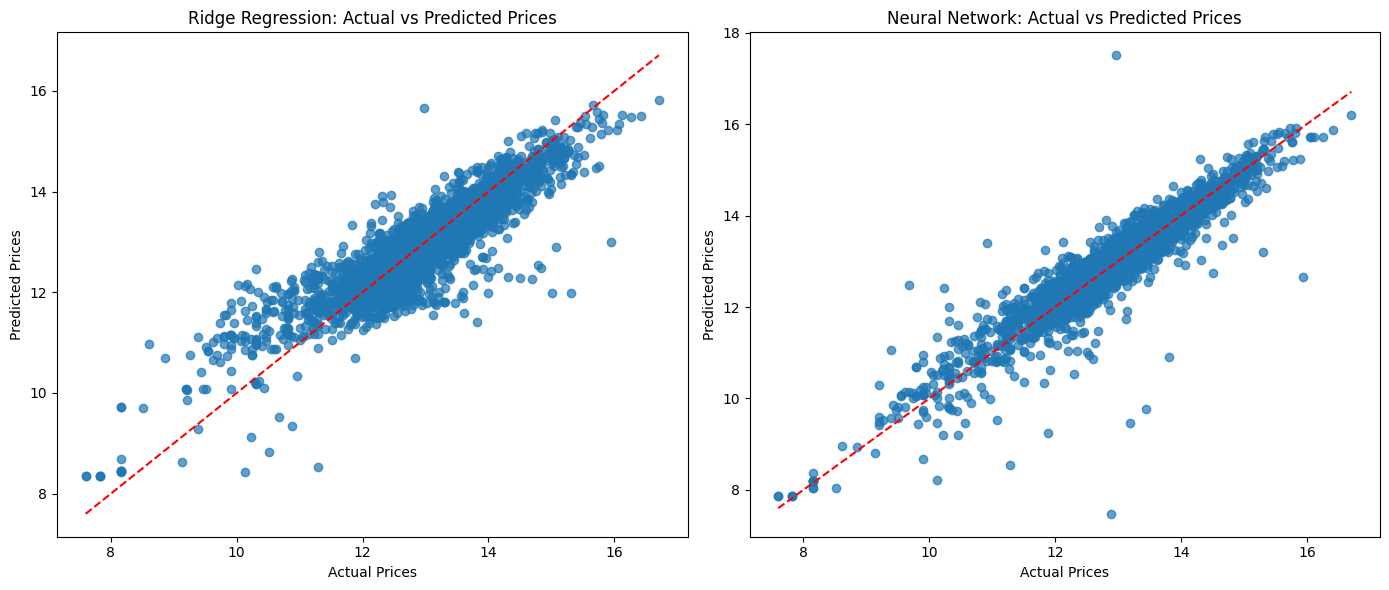

In [35]:
# Performance Metrics
#--------------------------

# Linear Regression Metrics
print("Linear Regression Metrics:")
print(f"Validation MAE: {mae_val:.2f}")
print(f"Validation MSE: {mse_val:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print("\n")

# Neural Network Metrics
print("Neural Network Metrics:")
print(f"Validation MAE: {val_mae:.2f}")
print(f"Validation MSE: {val_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")
print(f"Test MSE: {test_loss:.2f}")
print("\n")

# Interpretability
#--------------------------
# Ridge Regression (Linear model) offers clear interpretability as you can directly see the effect of each feature on the output.
# Neural Networks, being a black-box model, doesn't offer the same level of interpretability. It's harder to understand how each feature affects the output.

# Training Time
#--------------------------
# time the training for both models
start_time = time.time()
ridge.fit(X_train, y_train)
ridge_time = time.time() - start_time

start_time = time.time()
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)
nn_time = time.time() - start_time

print(f"Training time for Ridge Regression: {ridge_time:.2f} seconds")
print(f"Training time for Neural Network: {nn_time:.2f} seconds")
print("\n")

# Predictions Visualization
#--------------------------
plt.figure(figsize=(14, 6))

# Ridge Regression
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_pred_val, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Ridge Regression: Actual vs Predicted Prices')

# Neural Network
y_pred_nn_val = model.predict(X_val).flatten()
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_nn_val, alpha=0.7)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Neural Network: Actual vs Predicted Prices')

plt.tight_layout()
plt.show()

#### 6. Conclusion and Future Work




###### Conclusion:

- **Performance Metrics**: The Neural Network model has shown superior performance in terms of MAE and MSE as compared to the Ridge Regression. This indicates that the more complex model was able to better capture the patterns in the data.
- **Interpretability**: While the Ridge Regression model offers a clear understanding of feature importance, the Neural Network lacks this interpretability. This can be a trade-off between performance and understandability.
- **Training Time**: Neural networks generally take longer to train given their complexity. However, with the advancements in hardware and optimization techniques, this difference is becoming negligible in many cases.

###### Future Work:

1. **Feature Engineering**: More features could be derived from the existing data to improve the performance of the models.
2. **Hyperparameter Tuning**: A thorough search for optimal hyperparameters, especially for the Neural Network, could lead to even better results.
3. **Ensemble Techniques**: Combining multiple models can often lead to better performance. Techniques like stacking or blending can be explored.
4. **Deep Dive into Neural Network**: Given its superior performance, we could further explore architectures, regularization techniques, and other nuances to improve the Neural Network model.
5. **Addressing Data Collection Limitations**: Currently, the Redfin API has a limitation of 350 records per location. To achieve a decent sample size, a workaround was employed by merging data from various date subsets and dropping duplicates. Opening [an issue](https://github.com/ryansherby/RedfinScraper/issues/7) on the RedfinScraper GitHub repository suggests the need for an enhancement to address this limitation. Ideally, if Redfin increases this limit in the future, it would lead to more streamlined data collection and potentially richer datasets.

